In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [4]:
def calc_SA(trj,helix,start,stop):
 RMS_start=start
 RMS_stop=stop
 RMS=[]
 for i in range(RMS_start,RMS_stop):
    sel=helix.topology.select("residue %s to %s and name CA" % (i,i+6))
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
 RMS=np.asarray(RMS)
 Sa_sum=np.zeros((trj.n_frames))
 Sa=(1.0-(RMS/0.08)**8)/(1-(RMS/0.08)**12)
 return Sa


def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

In [5]:
def free_energy(a,b,T,y0,ymax,x0,xmax):
  free_energy,xedges,yedges=np.histogram2d(a,b,30,[[y0,ymax],[x0,xmax]],normed=True,weights=None)
  free_energy=np.log(np.flipud(free_energy)+.000001)
  free_energy=-(0.001987*T)*free_energy
  return free_energy,xedges,yedges

def free_energy_reweight(a, b, T, y0, ymax, x0, xmax,weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


In [6]:
def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd

In [7]:
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1
 dsspH[dsspH=='E']=0
 dsspH[dsspH=='C']=0
 dsspH[dsspH=='NA']=0
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1)
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspH[:,i].astype(float)
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5]

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1)
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E

In [8]:
def calc_phipsi(trj):
 indices_phi, phis = md.compute_phi(trj)
 indices_psi, psis = md.compute_psi(trj)
 phi_label=[]
 for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
      phi_label.append(resindex)
 phi_label=np.array(phi_label)
 #print(phi_label)
 psi_label=[]
 for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
      psi_label.append(resindex)
 psi_label=np.array(psi_label)
 #print(psi_label)
 phipsi=[]
 for i in range(0,len(phi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
 phipsi_array=np.array(phipsi)
 return(phipsi_array,psi_label,phi_label)

In [9]:
def block(x):
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    for i in arange(0,d):
        n = len(x)
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        s[i] = var(x)
        x = 0.5*(x[0::2] + x[1::2])

    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

In [12]:
pdb='/Users/kaushikb/Desktop/Paper_Repo/PaaA2/PaaA2.pdb'
trajectory='/Users/kaushikb/Desktop/Paper_Repo/PaaA2/Charmm36m/PaaA2-Charmm36m-Traj.dcd'
helixpdb='/Users/kaushikb/Desktop/Paper_Repo/PaaA2/PaaA2.helix.pdb'
outdir='/Users/kaushikb/Desktop/Paper_Repo/PaaA2/Charmm36m/reweight_trial/compare_ensembles/'
weight_file='/Users/kaushikb/Desktop/Paper_Repo/PaaA2/Charmm36m/reweight_trial/weights/combined_data/CA-CB-HA-H-N-C-RDC-SAXS/weights_final.dat'
weights=np.loadtxt(weight_file)
ppIIpdb='/Users/kaushikb/Desktop/Paper_Repo/PaaA2/PaaA2.ppII.pdb'
betapdb='/Users/kaushikb/Desktop/Paper_Repo/PaaA2/PaaA2.beta.pdb'

if not os.path.exists(outdir):
    os.makedirs(outdir)


print("outdir",outdir)
print("pdb",pdb)
print("helixpdb",helixpdb)
print("trajectory",trajectory)
print("weights_file",weight_file)

outdir /Users/kaushikb/Desktop/Paper_Repo/PaaA2/Charmm36m/reweight_trial/compare_ensembles/
pdb /Users/kaushikb/Desktop/Paper_Repo/PaaA2/PaaA2.pdb
helixpdb /Users/kaushikb/Desktop/Paper_Repo/PaaA2/PaaA2.helix.pdb
trajectory /Users/kaushikb/Desktop/Paper_Repo/PaaA2/Charmm36m/PaaA2-Charmm36m-Traj.dcd
weights_file /Users/kaushikb/Desktop/Paper_Repo/PaaA2/Charmm36m/reweight_trial/weights/combined_data/CA-CB-HA-H-N-C-RDC-SAXS/weights_final.dat


In [13]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
trj = trj[1:]
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [14]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

In [15]:
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 1165

Number of residues: 71

Number of protein residues: 71

Number of frames: 29976

Starting frame: 0

Last frame: 29976

sequence:  [MET1, ASP2, TYR3, LYS4, ASP5, ASP6, ASP7, ASP8, LYS9, ASN10, ARG11, ALA12, LEU13, SER14, PRO15, MET16, VAL17, SER18, GLU19, PHE20, GLU21, THR22, ILE23, GLU24, GLN25, GLU26, ASN27, SER28, TYR29, ASN30, GLU31, TRP32, LEU33, ARG34, ALA35, LYS36, VAL37, ALA38, THR39, SER40, LEU41, ALA42, ASP43, PRO44, ARG45, PRO46, ALA47, ILE48, PRO49, HIS50, ASP51, GLU52, VAL53, GLU54, ARG55, ARG56, MET57, ALA58, GLU59, ARG60, PHE61, ALA62, LYS63, MET64, ARG65, LYS66, GLU67, ARG68, SER69, LYS70, GLN71]

residue names:  ['MET', 'ASP', 'TYR', 'LYS', 'ASP', 'ASP', 'ASP', 'ASP', 'LYS', 'ASN', 'ARG', 'ALA', 'LEU', 'SER', 'PRO', 'MET', 'VAL', 'SER', 'GLU', 'PHE', 'GLU', 'THR', 'ILE', 'GLU', 'GLN', 'GLU', 'ASN', 'SER', 'TYR', 'ASN', 'GLU', 'TRP', 'LEU', 'ARG', 'ALA', 'LYS', 'VAL', 'ALA', 'THR', 'SER', 'LEU', 'ALA', 'ASP', 'PRO', 'ARG', 'PRO',

In [16]:
residue_offset=0
prot_res_renum=np.asarray(prot_res)+residue_offset
residue_number = range(0,residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)

Residue Number Range: range(0, 71)


In [17]:
dssp=md.compute_dssp(trj, simplified=True)
np.savetxt(outdir+"/dssp.out",dssp,fmt='%s')
H1_H,H1_E=dssp_convert(dssp)

/var/folders/yc/yv0526ns7wd5r003v79z9c080000gn/T/ipykernel_93573/1329944918.py:15: RuntimeWarning: invalid value encountered in divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


In [18]:
dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1
dsspH[dsspH=='E']=0
dsspH[dsspH=='C']=0
dsspH[dsspH=='NA']=0
dsspH=dsspH.astype(int)
np.savetxt(outdir+"/dssp.H.dat",dsspH,fmt='%i')
np.savetxt(outdir+"/Hprop.dat",np.column_stack((prot_res_renum,H1_H)),fmt="%.3f")

In [19]:
dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
np.savetxt(outdir+"/dssp.E.dat",dsspE,fmt='%i')
np.savetxt(outdir+"/Eprop.dat",np.column_stack((prot_res_renum,H1_E)),fmt="%.3f")

In [20]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5

In [21]:
Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)

reweight_Hprop=[]
reweight_Eprop=[]
for i in range(0,len(Hprop)):
    reweight_Hprop.append(np.dot(dsspH[:,i],weights))
    reweight_Eprop.append(np.dot(dsspE[:,i],weights))

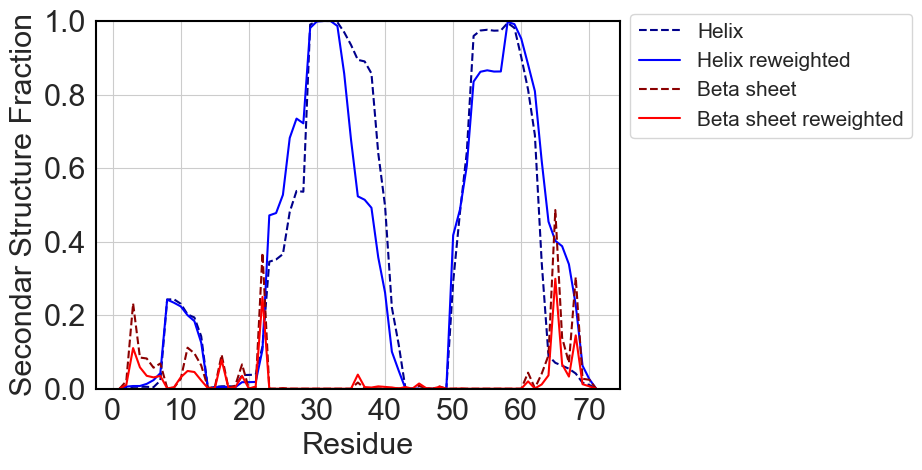

In [22]:
plt.clf()
plt.plot(prot_res_renum,Hprop,color='darkblue', label='Helix',linestyle='dashed')
plt.ylim(0,1.0)
plt.plot(prot_res_renum,reweight_Hprop,color='blue', label='Helix reweighted')
plt.plot(prot_res_renum,Eprop,color='darkred', label='Beta sheet',linestyle='dashed')
plt.plot(prot_res_renum,reweight_Eprop,color='red', label='Beta sheet reweighted')
plt.xlabel('Residue', size=22)
plt.ylabel('Secondar Structure Fraction', size=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.85), fontsize=15)
plt.savefig('%s/SS.reweight.pdf'%outdir, bbox_inches='tight')

In [23]:
rg=calc_Rg(trj)
np.savetxt(outdir+"/Rg.dat",rg,fmt="%.3f")
print("CA Radius of Gyration All:%6.3lf"%np.average(rg),"+_%6.3lf"%block(rg)**.5)
np.savetxt(outdir+"/Rg.ave.dat",np.column_stack((np.average(rg),block(rg)**.5)),fmt="%.3f")

CA Radius of Gyration All: 1.371 +_ 0.018


In [24]:
def pmf1d(x,nbins,range=None, weights = None, return_bin_centers = True):
    count,edge = np.histogram(x,bins = nbins,range=range,weights = weights)
    if weights is None:
        p = count/len(x)
    else:
        p = count
    if return_bin_centers:
        return p,edge[:-1]+np.diff(edge)/2
    else:
        return p  
    

p1, bc1 = pmf1d(rg, nbins=50)
p2, bc2 = pmf1d(rg, nbins=50, weights=weights)

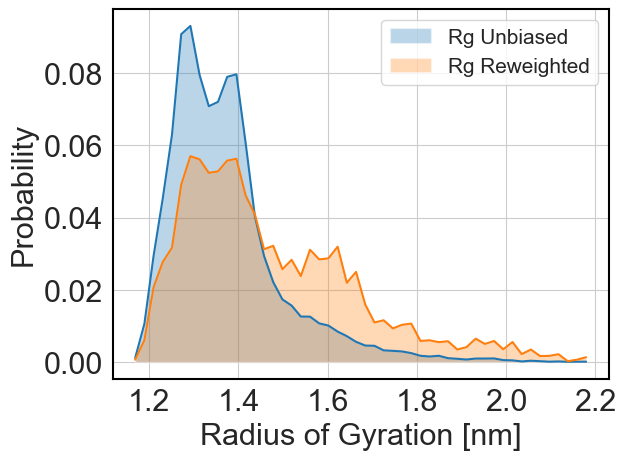

In [25]:
plt.plot(bc1,p1)
plt.plot(bc2,p2)
plt.fill_between(bc1,p1, alpha=0.3, label='Rg Unbiased')
plt.fill_between(bc2, p2, alpha=0.3, label='Rg Reweighted')
plt.legend(loc='upper right', fontsize=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Radius of Gyration [nm]',  fontsize=22)
plt.ylabel('Probability', fontsize=22)
plt.savefig('%s/Rg.probability.pdf'%outdir, bbox_inches='tight')

In [26]:
helixBB = md.load_pdb(helixpdb)
ppIIBB = md.load_pdb(ppIIpdb)
betaBB = md.load_pdb(betapdb)

trjBB = md.load(trajectory, top=pdb,stride=1)
trjBB = trjBB[1:]
BB=trjBB.topology.select("name CA")
HBB = helixBB.topology.select("name CA")
PBB=ppIIBB.topology.select("name CA")
BBB=betaBB.topology.select("name CA")


trjBB.restrict_atoms(BB)
helixBB.restrict_atoms(HBB)
ppIIBB.restrict_atoms(PBB)
betaBB.restrict_atoms(BBB)

trjBB.center_coordinates()
helixBB.center_coordinates()
betaBB.center_coordinates()
ppIIBB.center_coordinates()

Sa= calc_SA(trjBB,helixBB,0, 65)
Sa_ppII = calc_SA(trjBB,ppIIBB,0, 65)
Sa_beta = calc_SA(trjBB,betaBB,0, 65)

Sa_total=np.sum(Sa, axis=0)
Sa_ave=np.average(Sa,axis=1)
np.savetxt(outdir+"/Sa.dat",Sa,fmt="%.3f")
np.savetxt(outdir+"/Sa.total.dat",Sa_total,fmt="%.3f")

In [27]:
rg_nmr = [1.742, 2.477, 2.141, 2.049, 2.403, 1.954, 1.482, 2.042, 2.487,
       2.059, 2.154, 1.997, 1.763, 1.774, 1.824, 1.687, 2.085, 1.933,
       2.309, 2.398, 2.154, 2.149, 1.853, 2.754, 2.282, 2.142, 2.091,
       2.284, 2.500, 1.689, 1.620, 1.906, 2.193, 2.649, 2.596, 2.316,
       2.312, 1.764, 2.423, 2.111, 1.858, 1.739, 1.833, 1.803, 1.500,
       2.300, 2.237, 2.731, 1.569, 1.921]


sa_nmr= [25.437, 17.776, 18.060, 18.863, 22.582, 20.718, 22.404, 17.322,
       20.287, 24.573, 19.850, 22.882, 19.979, 21.065, 19.789, 22.055,
       21.818, 23.304, 22.764, 19.602, 19.045, 23.159, 25.806, 16.820,
       18.496, 21.387, 20.129, 21.180, 19.583, 21.788, 21.902, 20.857,
       19.595, 22.899, 20.671, 24.207, 22.452, 21.754, 23.335, 22.418,
       19.665, 20.448, 17.662, 20.444, 21.512, 21.027, 19.664, 21.793,
       18.983, 23.190]

In [28]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0


def plot_Rg_vs_Sa(a, b, T, y0, ymax, x0, xmax, scatter_x=None, scatter_y=None, weight=None, title="", filename="plot.pdf"):
    # Calculate free energy
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy) + 0.000001)
    free_energy = -(0.001987 * T) * free_energy

    # Create and customize the plot
    fig = plt.figure(figsize=(10, 8))
    plt.scatter(scatter_x, scatter_y, marker='.', c='white', s=800, edgecolors='black', alpha=0.8)
    im = plt.imshow(free_energy, interpolation='gaussian', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    cmap='jet', aspect='auto')
    plt.title(title, fontsize=30, pad=20)
    cbar_ticks = [0, 1, 2, 3]
    cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=15)
    cb.set_label("Free Energy (kcal/mol)", labelpad=35, fontsize=30, rotation=270)
    imaxes = plt.gca()
    plt.ylabel("Radius of Gyration [nm]", size=35, labelpad=15)
    plt.xlabel(r"S$\alpha$", size=35, labelpad=15)
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.axes(cb.ax)
    plt.clim(vmin=0.1, vmax=3.0)
    #plt.yticks(size='26')
    cb.ax.tick_params(labelsize=30)
    
    #create the path
    file_path = os.path.join(outdir, filename)
    
    
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

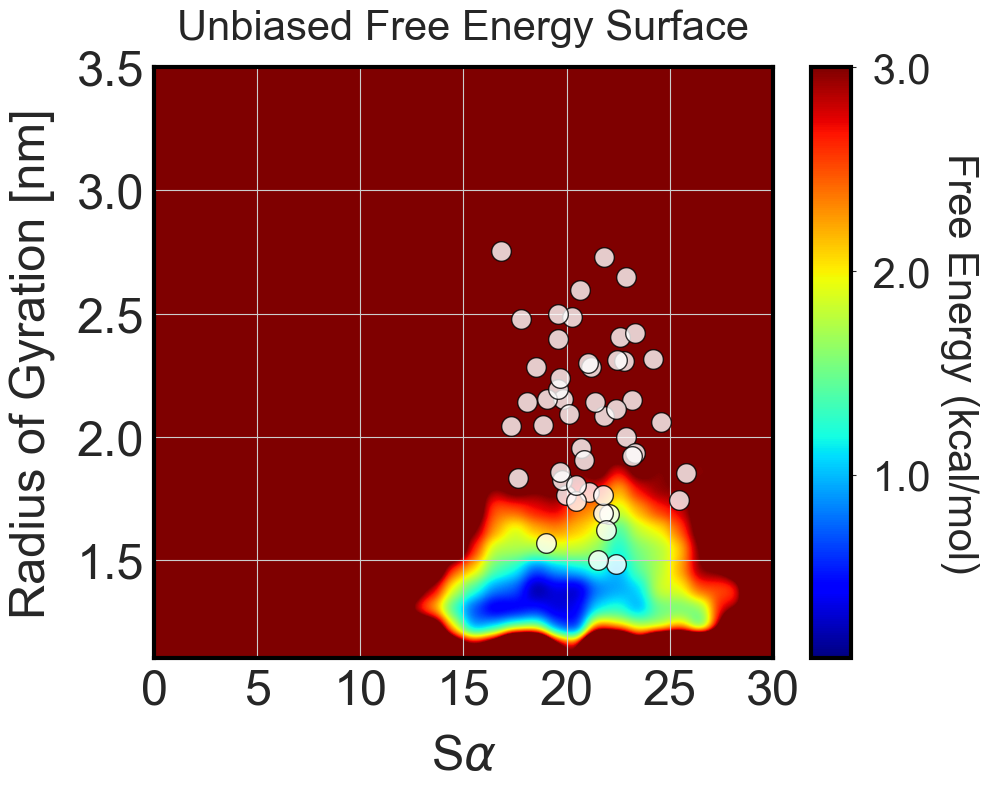

In [29]:
plot_Rg_vs_Sa(rg, Sa_total, 300, 1.1, 3.5, 0, 30, scatter_x=sa_nmr, scatter_y=rg_nmr, weight=None, title='Unbiased Free Energy Surface', filename='unbiased.rg_vs_sa.pdf')

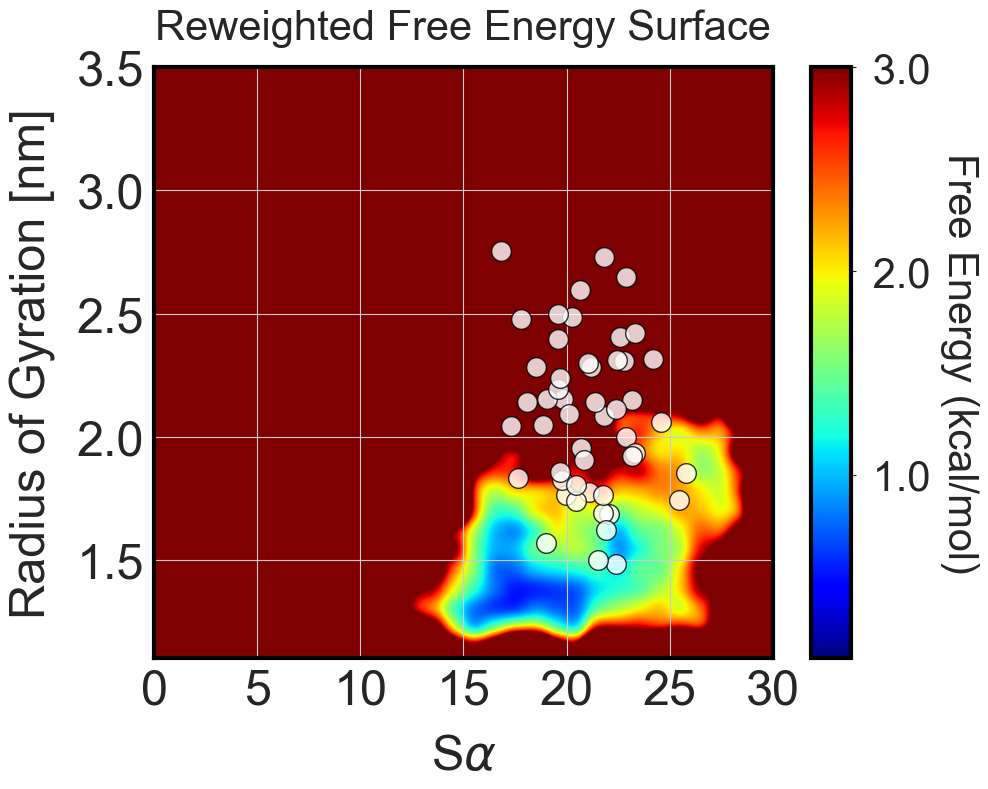

In [30]:
plot_Rg_vs_Sa(rg, Sa_total, 300, 1.1, 3.5, 0, 30, scatter_x=sa_nmr, scatter_y=rg_nmr, weight=weights, title='Reweighted Free Energy Surface', filename='reweighted.rg_vs_sa.pdf')

In [31]:
contact_maps = []
distance_maps= []

contact_maps_reweight = []
distance_maps_reweight = []

for i in range(0,71):
    contact_map = []
    distance_map = []

    contact_map_reweight = []
    distance_map_reweight = []
    for j in range(0,71):
        if i == j:
            contacts = 0
            contacts_reweight = 0
            distance = 0
            distance_reweight =0
        else:
            dist = md.compute_contacts(trj,[[i,j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            distance_reweight= np.dot(array[:,0],weights)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
            contacts_reweight = np.dot(contact[:,0],weights)
        distance_map.append(distance)
        distance_map_reweight.append(distance_reweight)
        contact_map.append(contacts)
        contact_map_reweight.append(contacts_reweight)
    contact_maps.append(contact_map)
    contact_maps_reweight.append(contact_map_reweight)
    distance_maps.append(distance_map)
    distance_maps_reweight.append(distance_map_reweight)

final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(distance_maps).astype(float)

final_map_reweight = np.asarray(contact_maps_reweight).astype(float)
final_distance_reweight = np.asarray(distance_maps_reweight).astype(float)

In [32]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)

71

In [33]:
n=7
for i in range (0,len(sequence)):
  if (i % n !=0):
   sequence[i]=''

print(sequence)

[MET1, '', '', '', '', '', '', ASP8, '', '', '', '', '', '', PRO15, '', '', '', '', '', '', THR22, '', '', '', '', '', '', TYR29, '', '', '', '', '', '', LYS36, '', '', '', '', '', '', ASP43, '', '', '', '', '', '', HIS50, '', '', '', '', '', '', MET57, '', '', '', '', '', '', MET64, '', '', '', '', '', '', GLN71]


In [34]:
def plot_cmaps(map_data, residues, title=" ", filename = " " ):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    im = sns.heatmap(map_data, cmap = 'jet', ax = ax)
    ax.grid(which='both', alpha=0.5)


    plt.xticks(range(0,residues), sequence[0:residues], rotation=45, size=22)
    plt.yticks(range(0,residues),sequence[0:residues], rotation=45, size=22)

    cbar = im.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('Residue contact probability', labelpad=35, fontsize=30, rotation= 270)
    ax.set_title(title, size=30, pad=20 )
    ax.invert_yaxis()
    plt.tight_layout()
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
    for _, spine in cbar.ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
    
    filepath= os.path.join(outdir, filename)
    plt.savefig(filepath)

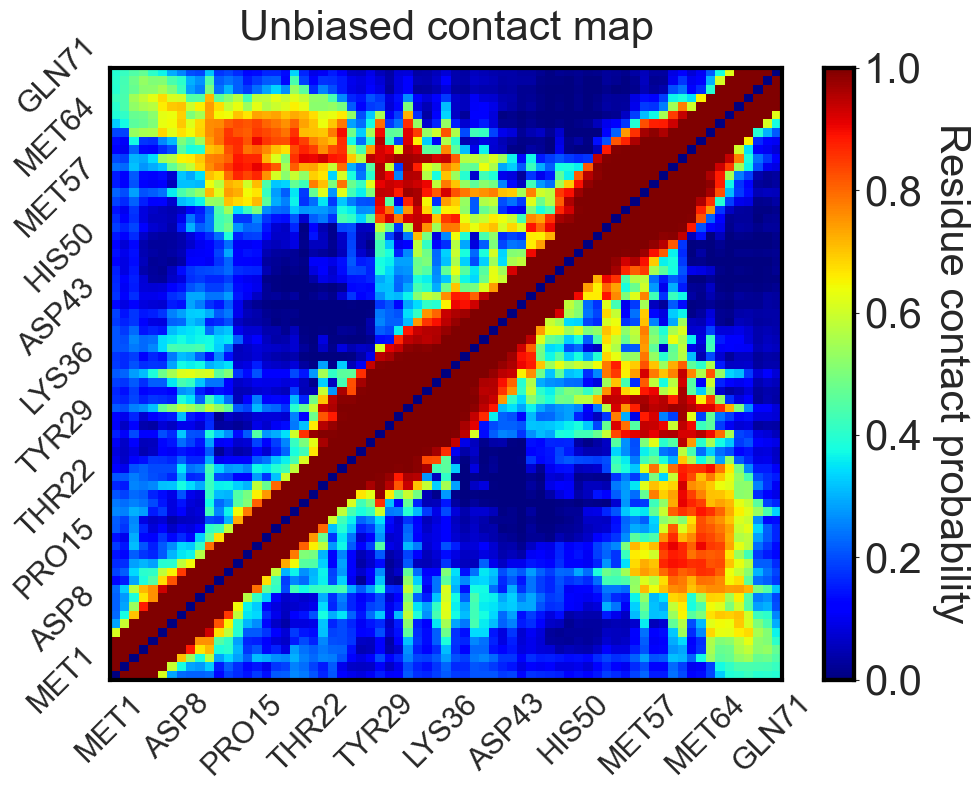

In [35]:
plot_cmaps(final_map, residues, title='Unbiased contact map', filename= "Unbiased_cmap.pdf")

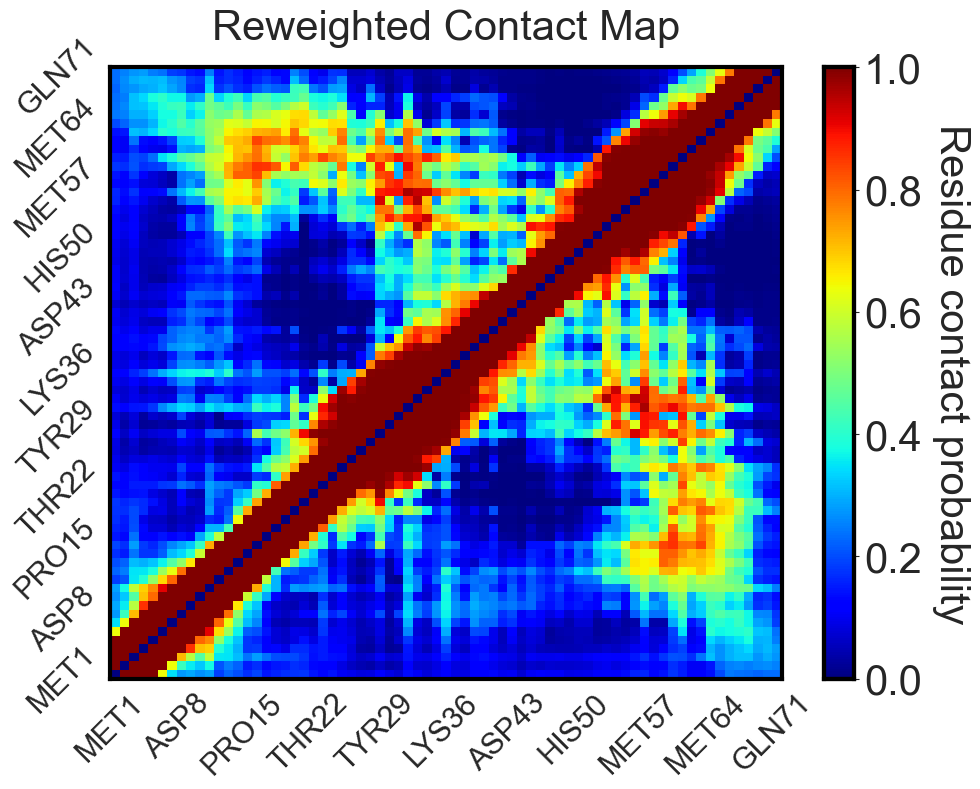

In [36]:
plot_cmaps(final_map_reweight, residues, title= 'Reweighted Contact Map', filename='Reweighted_cmap.pdf')